In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import optuna

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/reservation-cancellation-prediction/train__dataset.csv
/kaggle/input/reservation-cancellation-prediction/test___dataset.csv
/kaggle/input/playground-series-s3e7/sample_submission.csv
/kaggle/input/playground-series-s3e7/train.csv
/kaggle/input/playground-series-s3e7/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e7/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e7/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s3e7/sample_submission.csv')
addition_data = pd.read_csv('/kaggle/input/reservation-cancellation-prediction/train__dataset.csv')

train_df['is_generated'] = 1
test_df['is_generated'] = 1
addition_data['is_generated'] = 0

# train_df['is_test'] = 0
# test_df['is_test'] = 1
# addition_data['is_test'] = 0

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42100 entries, 0 to 42099
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    42100 non-null  int64  
 1   no_of_adults                          42100 non-null  int64  
 2   no_of_children                        42100 non-null  int64  
 3   no_of_weekend_nights                  42100 non-null  int64  
 4   no_of_week_nights                     42100 non-null  int64  
 5   type_of_meal_plan                     42100 non-null  int64  
 6   required_car_parking_space            42100 non-null  int64  
 7   room_type_reserved                    42100 non-null  int64  
 8   lead_time                             42100 non-null  int64  
 9   arrival_year                          42100 non-null  int64  
 10  arrival_month                         42100 non-null  int64  
 11  arrival_date   

In [4]:
train_df

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,is_generated
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0,1
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0,1
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0,1
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0,1
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42095,42095,3,0,0,4,0,0,1,160,2018,12,30,1,0,0,0,140.00,2,1,1
42096,42096,2,0,0,3,0,0,0,34,2017,9,23,0,0,0,0,224.67,0,0,1
42097,42097,2,0,0,2,2,0,0,292,2018,7,21,0,0,0,0,96.00,0,0,1
42098,42098,1,0,0,3,0,0,0,5,2018,11,9,0,0,0,0,120.00,0,0,1


In [5]:
addition_data.isna().any()

no_of_adults                            False
no_of_children                          False
no_of_weekend_nights                    False
no_of_week_nights                       False
type_of_meal_plan                       False
required_car_parking_space              False
room_type_reserved                      False
lead_time                               False
arrival_year                            False
arrival_month                           False
arrival_date                            False
market_segment_type                     False
repeated_guest                          False
no_of_previous_cancellations            False
no_of_previous_bookings_not_canceled    False
avg_price_per_room                      False
no_of_special_requests                  False
booking_status                          False
is_generated                            False
dtype: bool

<AxesSubplot:>

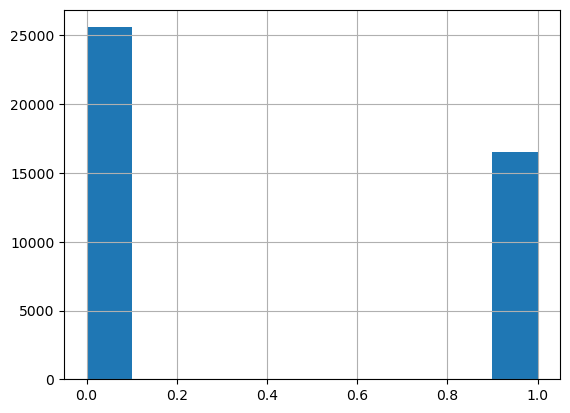

In [6]:
train_df.booking_status.hist()

In [7]:
train_df = pd.concat([train_df, addition_data],axis=0, ignore_index=True)

In [8]:
# train_df = train_df.drop_duplicates()

In [9]:
df = pd.concat([train_df, test_df], axis=0)
df = df.drop('id', axis=1)
df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,is_generated
0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0.0,1
1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0.0,1
2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0.0,1
3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0.0,1
4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28063,2,0,1,2,0,0,0,315,2018,9,30,1,0,0,0,160.00,0,NaN,1
28064,2,0,2,2,0,0,0,81,2018,3,25,0,0,0,0,65.00,1,NaN,1
28065,2,0,1,2,0,0,0,40,2018,10,22,0,0,0,0,85.00,0,NaN,1
28066,3,0,0,4,0,0,1,4,2018,9,6,1,0,0,0,162.75,0,NaN,1


In [10]:
# feat1 = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
#        'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
#        'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
#        'arrival_date', 'market_segment_type', 'repeated_guest',
#        'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
#        'avg_price_per_room', 'no_of_special_requests']
# df = df.drop_duplicates(subset=feat1, keep=False)
# df = df[df.is_test == 0]

In [11]:
# df = pd.concat([df, test_df], axis=0)
# df = df.drop(['id', 'is_test'], axis=1)
# df

Feature engneering from this amazing notebook:
https://www.kaggle.com/code/sergiosaharovskiy/ps-s3e7-2023-eda-and-submission#Basic-Feature-Engineering
Please, upvote it!

In [12]:
from pandas.tseries.holiday import USFederalHolidayCalendar

def fe(df):
        # Fix date anomalies (pd.to_datetime throws parsing error for some days, see anomalies section).
        df['arrival_year_month'] = pd.to_datetime(df['arrival_year'].astype(str) + df['arrival_month'].astype(str), format='%Y%m')
        df.loc[df.arrival_date > df.arrival_year_month.dt.days_in_month, 'arrival_date'] = df.loc[df.arrival_date > df.arrival_year_month.dt.days_in_month, 'arrival_year_month'].dt.days_in_month
        df.drop(columns='arrival_year_month', inplace=True)
        
        # Creates date features.
        df['arrival_full_date'] = (df['arrival_year'].astype(str) 
                                   + '-' + df['arrival_month'].astype(str)
                                   + '-' + df['arrival_date'].astype(str))
        df['arrival_full_date'] = pd.to_datetime(df.arrival_full_date)
#         df['arrival_week'] = df['arrival_full_date'].dt.isocalendar().week.astype(float)
#         df['arrival_dayofweek'] = df['arrival_full_date'].dt.dayofweek
#         df['arrival_quarter'] = df['arrival_full_date'].dt.quarter
#         df['arrival_dayofyear'] = df['arrival_full_date'].dt.dayofyear
        
        # Creates the season and holiday features. (also you can add holidays).
#         ['winter', 'spring', 'summer', 'fall']
#         df['season'] = df.arrival_month%12 // 3 + 1
#         cal = USFederalHolidayCalendar()
#         holidays = cal.holidays(start='2017-01-01', end='2018-12-31')
#         df['is_holiday'] = 0
#         df.loc[df.arrival_full_date.isin(holidays), 'is_holiday'] = 1
        
        # Aggregation by `season` as key and 'avg_price_per_room' as value (you can try quarters, months, etc).
#         key = 'season'
#         aggr_df = df.groupby(by=key, sort=False)['avg_price_per_room'].agg(['mean', 'std', 'min', 'max', 'sum', 'last'])
#         aggr_df = aggr_df.add_prefix('avg_price_per_room_')
#         df = df.merge(aggr_df.reset_index(), on=key, how='left')
        
        # Interaction between the correlated features and also lead time.
        df['no_of_adults_div_price'] = df.no_of_adults / (df.avg_price_per_room + 1e-6)
        df['no_of_children_div_price'] = df.no_of_children / (df.avg_price_per_room + 1e-6)
        df['lead_time_div_price'] = df.lead_time / (df.avg_price_per_room + 1e-6)
        df.drop(columns=['arrival_full_date'], inplace=True)
        return df

In [13]:
df = fe(df)
# df = df.drop(['no_of_children', 'no_of_previous_cancellations'], axis=1)
df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,...,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,is_generated,no_of_adults_div_price,no_of_children_div_price,lead_time_div_price
0,2,0,0,2,1,0,0,9,2018,1,...,1,11,0,67.50,0,0.0,1,0.029630,0.0,0.133333
1,2,0,1,2,0,0,0,117,2018,7,...,0,0,0,72.25,0,0.0,1,0.027682,0.0,1.619377
2,2,0,0,1,0,0,0,315,2018,12,...,0,0,0,52.00,0,0.0,1,0.038462,0.0,6.057692
3,1,0,0,2,1,0,0,32,2018,12,...,0,0,0,56.00,0,0.0,1,0.017857,0.0,0.571429
4,2,0,1,0,0,0,0,258,2018,10,...,0,0,0,100.00,0,1.0,1,0.020000,0.0,2.580000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28063,2,0,1,2,0,0,0,315,2018,9,...,0,0,0,160.00,0,NaN,1,0.012500,0.0,1.968750
28064,2,0,2,2,0,0,0,81,2018,3,...,0,0,0,65.00,1,NaN,1,0.030769,0.0,1.246154
28065,2,0,1,2,0,0,0,40,2018,10,...,0,0,0,85.00,0,NaN,1,0.023529,0.0,0.470588
28066,3,0,0,4,0,0,1,4,2018,9,...,0,0,0,162.75,0,NaN,1,0.018433,0.0,0.024578


In [14]:
features = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests',
       'is_generated', 'no_of_adults_div_price', 'no_of_children_div_price',
       'lead_time_div_price']

In [15]:
cat_features = [
    'required_car_parking_space',
    'market_segment_type',
    'room_type_reserved', 
    'repeated_guest',
    'type_of_meal_plan',
    'is_generated'
]

In [16]:
# for feat in cat_features:
#     dummies = pd.get_dummies(df[feat], prefix=f'is_{feat}')
#     dummies_columns = dummies.columns.values.tolist()
#     df[dummies_columns] = dummies
    
# df = df.drop(cat_features, axis=1)

# df

In [17]:
# from category_encoders import WOEEncoder

# woe = WOEEncoder(drop_invariant=True, randomized = True)
# for col in cat_features:
#     df[col] = df[col].astype(str)
# woe.fit(df[features][:-len(test_df)], df['booking_status'][:-len(test_df)], cols = cat_features)
# X = woe.transform(df[features])
# X['booking_status'] = df['booking_status']
# df = X

# df

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

y = df['booking_status']
df = df.drop(['booking_status'], axis=1)

df[df.columns] = scaler.fit_transform(df[df.columns])

In [19]:
train_df = df.iloc[:-len(test_df),:]
train_df['booking_status'] = y[:-len(test_df)]
test_df = df.iloc[-len(test_df):,:].reset_index(drop=True)

# oversample = train_df[train_df['Class']==1]
# undersample = train_df[train_df['Class']==0]

X = train_df.drop(['booking_status'], axis=1)
y = train_df.booking_status.astype('int')
X_test = test_df

In [20]:
from sklearn.model_selection import train_test_split

# X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

# X, y = X_train, y_train
# X1, y1 = X_test1, y_test1

In [21]:
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold

n_folds = 5 #6 -
repeats = 2 #5 - 

In [22]:
!pip install scikit-optimize

# import scikit-optimize as skopt

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [23]:
import catboost
from sklearn.utils.class_weight import compute_sample_weight

MAX_ITER = 15000
PATIENCE = 500 #50 #1000
DISPLAY_FREQ = 100

modelsCBC = []
predsCBC = []

# k_fold = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42) 

gpu_params = {'task_type' : "GPU", 'devices' : '0:1'}
cbc_params = {'iterations': 5000, #164,
              'max_depth': 6, #5, #10,
              'learning_rate': 0.055, #0.05, #0.1, 
              'verbose': 100,
              'eval_metric': 'AUC',
              'loss_function': 'Logloss',
#               **gpu_params
             }

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = catboost.CatBoostClassifier(**cbc_params)
#     model = catboost.CatBoostRegressor(**MODEL_PARAMS)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
#           metric_period = DISPLAY_FREQ
         )
    modelsCBC.append(model)
    predsCBC.append(model.predict_proba(X_test))
#     predsCBC.append(model.predict(X_test))

0:	test: 0.8494215	best: 0.8494215 (0)	total: 74.3ms	remaining: 6m 11s
100:	test: 0.8927749	best: 0.8927749 (100)	total: 1.6s	remaining: 1m 17s
200:	test: 0.9003189	best: 0.9003189 (200)	total: 3.11s	remaining: 1m 14s
300:	test: 0.9044147	best: 0.9044147 (300)	total: 4.6s	remaining: 1m 11s
400:	test: 0.9074114	best: 0.9074114 (400)	total: 6.13s	remaining: 1m 10s
500:	test: 0.9093707	best: 0.9093707 (500)	total: 7.71s	remaining: 1m 9s
600:	test: 0.9108188	best: 0.9108188 (600)	total: 9.26s	remaining: 1m 7s
700:	test: 0.9120157	best: 0.9120157 (700)	total: 12s	remaining: 1m 13s
800:	test: 0.9128169	best: 0.9128219 (794)	total: 13.5s	remaining: 1m 10s
900:	test: 0.9134998	best: 0.9134998 (900)	total: 15s	remaining: 1m 8s
1000:	test: 0.9140030	best: 0.9140030 (1000)	total: 16.5s	remaining: 1m 6s
1100:	test: 0.9145569	best: 0.9145666 (1095)	total: 18s	remaining: 1m 3s
1200:	test: 0.9150077	best: 0.9150077 (1200)	total: 19.5s	remaining: 1m 1s
1300:	test: 0.9154633	best: 0.9154633 (1300)	tota

In [24]:
feature_importance =  [modelsCBC[x].feature_importances_ for x in range(n_folds*repeats)]
feature_importance = np.average(feature_importance,axis=0)
feature_importance

array([ 1.11161978,  0.08503745,  2.58630776,  3.85467261,  1.36154218,
        1.86666956,  1.50398774, 21.1413206 ,  1.75210808,  8.21382738,
        6.17714037,  8.36402072,  1.19855914,  0.04035221,  0.63449624,
       14.49609354, 13.17394295,  3.70087712,  3.16456506,  1.05471787,
        4.51814164])

Text(0.5, 1.0, 'Feature Importance')

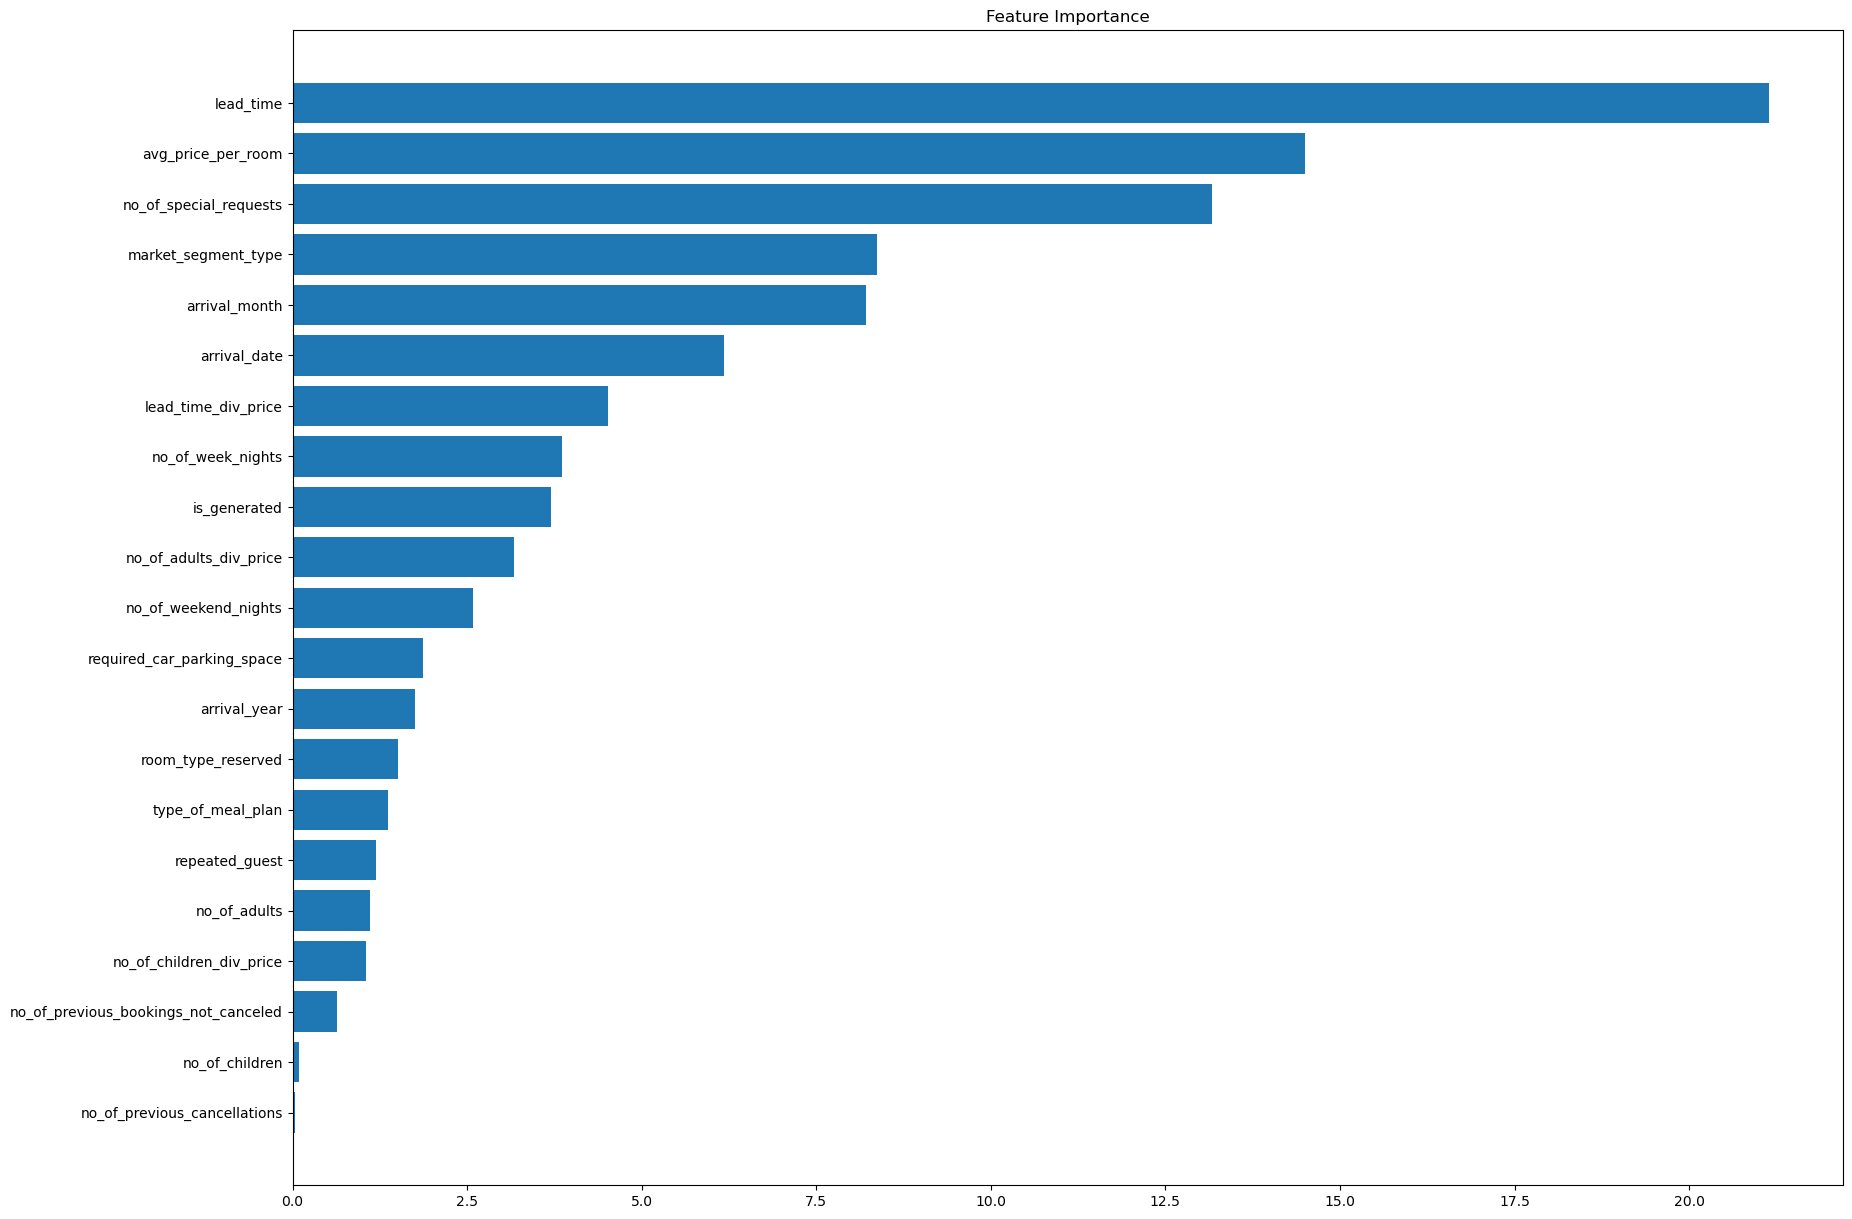

In [25]:
import matplotlib.pyplot as plt

# feature_importance = modelsCBC[0].feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(20, 15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [26]:
from xgboost import XGBClassifier, XGBRegressor

k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42) 

modelsXBC = []
predsXBC = []

PATIENCE = 50 #500

xgbc_params = {'n_estimators': 3000, #54, 
               'max_depth': 5, #10, #3, 
               'learning_rate': 0.05, 
               'subsample': 0.568355005569169, 
               'eval_metric'     : 'auc',
               'objective'       : 'binary:logistic',
#                'tree_method': 'gpu_hist'
              }

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = XGBClassifier(**xgbc_params)
#     model = XGBRegressor(**MODEL_PARAMS)
    
    model.fit(X=X_train, y=y_train,
#               sample_weight=weights,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
          verbose = 100
         )
    modelsXBC.append(model)
    predsXBC.append(model.predict_proba(X_test))


[0]	validation_0-auc:0.86220
[100]	validation_0-auc:0.89919
[200]	validation_0-auc:0.90652
[300]	validation_0-auc:0.91045
[400]	validation_0-auc:0.91262
[500]	validation_0-auc:0.91403
[600]	validation_0-auc:0.91490
[700]	validation_0-auc:0.91564
[800]	validation_0-auc:0.91619
[900]	validation_0-auc:0.91665
[1000]	validation_0-auc:0.91692
[1010]	validation_0-auc:0.91692
[0]	validation_0-auc:0.85584
[100]	validation_0-auc:0.89494
[200]	validation_0-auc:0.90338
[300]	validation_0-auc:0.90757
[400]	validation_0-auc:0.91004
[500]	validation_0-auc:0.91147
[600]	validation_0-auc:0.91222
[700]	validation_0-auc:0.91282
[800]	validation_0-auc:0.91331
[900]	validation_0-auc:0.91377
[1000]	validation_0-auc:0.91388
[1100]	validation_0-auc:0.91413
[1140]	validation_0-auc:0.91410
[0]	validation_0-auc:0.86201
[100]	validation_0-auc:0.89721
[200]	validation_0-auc:0.90439
[300]	validation_0-auc:0.90831
[400]	validation_0-auc:0.91034
[500]	validation_0-auc:0.91198
[600]	validation_0-auc:0.91325
[700]	val

In [27]:
import lightgbm as lgbm

k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42) 

modelsLBC = []
predsLBC = []

PATIENCE = 50 #200

classes = np.unique(y)
weights = compute_sample_weight("balanced", y=y)
class_weights = dict(zip(classes, weights))

gpu_params = {'device' : "gpu"}
gbc_params = {'n_estimators': 5000, 
              'max_depth': 5, #10, 
              'num_leaves': 8,
              'learning_rate': 0.05, #0.1, 
              'subsample': 0.8501198417003352,
              'lambda_l1': 3,
              'lambda_l2': 3,
              'bagging_fraction': 0.8,
              'feature_fraction': 0.8,
              'objective': 'binary',
              'metric': 'auc',
#               **gpu_params
             }

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = lgbm.LGBMClassifier(**gbc_params)
#     model = lgbm.LGBMRegressor(**MODEL_PARAMS)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
          verbose = 100
         )
    modelsLBC.append(model)
    predsLBC.append(model.predict_proba(X_test))


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8501198417003352 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[100]	valid_0's auc: 0.884467
[200]	valid_0's auc: 0.894347
[300]	valid_0's auc: 0.899198
[400]	valid_0's auc: 0.902091
[500]	valid_0's auc: 0.904472
[600]	valid_0's auc: 0.906212
[700]	valid_0's auc: 0.907618
[800]	valid_0's auc: 0.90886
[900]	valid_0's auc: 0.909654
[1000]	valid_0's auc: 0.910382
[1100]	valid_0's auc: 0.91111
[1200]	valid_0's auc: 0.911681
[1300]	valid_0's auc: 0.912161
[1400]	valid_0's auc: 0.912638
[1500]	valid_0's auc: 0.913035
[1600]	valid_0's auc: 0.9134
[1700]	valid_0's auc: 0.913658
[1800]	valid_0's auc: 0.91389
[

In [28]:
PATIENCE = 100

modelsCB = []
predsCB = []

k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42) 

gpu_params = {'task_type' : "GPU", 'devices' : '0:1'}
cbr_params = {'iterations': 2000, 
              'max_depth': 7,
              'learning_rate': 0.05, #0.1, # 0.05, 
              'verbose': 100,
#               **gpu_params
             }

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = catboost.CatBoostRegressor(**cbr_params)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
         )
    modelsCB.append(model)
    predsCB.append(model.predict(X_test))

0:	learn: 0.4746126	test: 0.4745843	best: 0.4745843 (0)	total: 14.7ms	remaining: 29.5s
100:	learn: 0.3578191	test: 0.3584886	best: 0.3584886 (100)	total: 1.1s	remaining: 20.6s
200:	learn: 0.3497370	test: 0.3521835	best: 0.3521835 (200)	total: 3.18s	remaining: 28.4s
300:	learn: 0.3433743	test: 0.3479366	best: 0.3479366 (300)	total: 4.28s	remaining: 24.1s
400:	learn: 0.3388842	test: 0.3452695	best: 0.3452695 (400)	total: 5.35s	remaining: 21.3s
500:	learn: 0.3352465	test: 0.3434904	best: 0.3434904 (500)	total: 6.47s	remaining: 19.4s
600:	learn: 0.3324015	test: 0.3423567	best: 0.3423567 (600)	total: 7.5s	remaining: 17.4s
700:	learn: 0.3295570	test: 0.3411939	best: 0.3411890 (699)	total: 8.54s	remaining: 15.8s
800:	learn: 0.3270507	test: 0.3403344	best: 0.3403344 (800)	total: 9.6s	remaining: 14.4s
900:	learn: 0.3245280	test: 0.3395800	best: 0.3395800 (900)	total: 10.7s	remaining: 13s
1000:	learn: 0.3222789	test: 0.3389035	best: 0.3389035 (1000)	total: 11.7s	remaining: 11.7s
1100:	learn: 0.3

In [29]:
from xgboost import XGBClassifier, XGBRegressor

k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42) 

modelsXB = []
predsXB = []

PATIENCE = 50

xgbr_params = {'n_estimators': 2000, 
               'max_depth': 5,
               'learning_rate': 0.05, 
               'subsample': 0.8291850469303983,
#                'tree_method': 'gpu_hist'
              }


for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = XGBRegressor(**xgbr_params)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
          verbose = 100
         )
    modelsXB.append(model)
    predsXB.append(model.predict(X_test))

[0]	validation_0-rmse:0.48913
[100]	validation_0-rmse:0.35084
[200]	validation_0-rmse:0.34483
[300]	validation_0-rmse:0.34199
[400]	validation_0-rmse:0.33979
[500]	validation_0-rmse:0.33820
[600]	validation_0-rmse:0.33705
[700]	validation_0-rmse:0.33617
[800]	validation_0-rmse:0.33541
[900]	validation_0-rmse:0.33495
[1000]	validation_0-rmse:0.33455
[1100]	validation_0-rmse:0.33416
[1200]	validation_0-rmse:0.33389
[1300]	validation_0-rmse:0.33373
[1400]	validation_0-rmse:0.33355
[1457]	validation_0-rmse:0.33356
[0]	validation_0-rmse:0.48927
[100]	validation_0-rmse:0.35452
[200]	validation_0-rmse:0.34846
[300]	validation_0-rmse:0.34467
[400]	validation_0-rmse:0.34213
[500]	validation_0-rmse:0.34094
[600]	validation_0-rmse:0.34002
[700]	validation_0-rmse:0.33941
[800]	validation_0-rmse:0.33885
[900]	validation_0-rmse:0.33842
[1000]	validation_0-rmse:0.33810
[1100]	validation_0-rmse:0.33785
[1200]	validation_0-rmse:0.33772
[1288]	validation_0-rmse:0.33773
[0]	validation_0-rmse:0.48915
[100

In [30]:
import lightgbm as lgbm
k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42) 

modelsLB = []
predsLB = []

PATIENCE = 50

gpu_params = {'device' : "gpu"}
lgbr_params = {'n_estimators': 10000, 
               'metric': 'rmse',
               'max_depth': 8, #10, #8
               'num_leaves': 8,
               'learning_rate': 0.1, #0.05, # 0.1
               'subsample': 0.944652288803578,
               'lambda_l1': 3,
               'lambda_l2': 3,
               'bagging_fraction': 0.8, 
               'feature_fraction': 0.8,
#                **gpu_params
              }

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = lgbm.LGBMRegressor(**lgbr_params)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
          verbose = 100
         )
    modelsLB.append(model)
    predsLB.append(model.predict(X_test))

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.944652288803578 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[100]	valid_0's rmse: 0.357838
[200]	valid_0's rmse: 0.351706
[300]	valid_0's rmse: 0.347897
[400]	valid_0's rmse: 0.345445
[500]	valid_0's rmse: 0.343824
[600]	valid_0's rmse: 0.34274
[700]	valid_0's rmse: 0.341606
[800]	valid_0's rmse: 0.340731
[900]	valid_0's rmse: 0.34012
[1000]	valid_0's rmse: 0.339619
[1100]	valid_0's rmse: 0.33906
[1200]	valid_0's rmse: 0.338651
[1300]	valid_0's rmse: 0.33834
[1400]	valid_0's rmse: 0.338106
[1500]	valid_0's rmse: 0.337647
[1600]	valid_0's rmse: 0.337329
[1700]	valid_0's rmse: 0.337114
[1800]	valid_0'

In [31]:
from sklearn.linear_model import LassoCV, Lasso

k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=2*repeats, random_state=42)  

modelsLR = []
predsLR = []

MODEL_PARAMS = {
                       'precompute': "auto",
                       'fit_intercept': True,
                       'normalize': False,
                       'max_iter': 10000,
                       'verbose': False,
                       'eps': 0.0001,
                       'cv': 5,
                       'n_alphas': 1000,
                       'n_jobs': 8,
#                        'tol': 0.0001
}


for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = LassoCV(**MODEL_PARAMS)
    
    model.fit(X=X_train, y=y_train,
#           eval_set=[(X_valid, y_valid)],
         )
    
    modelsLR.append(model)
    predsLR.append(model.predict(X_test))

In [32]:
from sklearn.metrics import roc_auc_score, precision_score, cohen_kappa_score

 
def coef_objective(trial):
    a = trial.suggest_float('a', 0, 1)
    b = trial.suggest_float('b', 0, 1)
    c = trial.suggest_float('c', 0, 1)
    d = trial.suggest_float('d', 0, 1)
    e = trial.suggest_float('e', 0, 1)
    f = trial.suggest_float('f', 0, 1)
    g = trial.suggest_float('g', 0, 1)

#     X = X1
#     y = y1
    
    preds_eval = []
    for model in modelsCBC:
        preds_eval.append(model.predict_proba(X))
    
    resCBC = np.average(np.array(preds_eval),axis=0)[:, 1]
    
    preds_eval = []
    for model in modelsXBC:
        preds_eval.append(model.predict_proba(X))
    
    resXBC = np.average(np.array(preds_eval),axis=0)[:, 1]
    
    preds_eval = []
    for model in modelsLBC:
        preds_eval.append(model.predict_proba(X))
    
    resLBC = np.average(np.array(preds_eval),axis=0)[:, 1]
    
    preds_eval = []
    for model in modelsCB:
        preds_eval.append(model.predict(X))
    
    resCB = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsXB:
        preds_eval.append(model.predict(X))
    
    resXB = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsLB:
        preds_eval.append(model.predict(X))
    
    resLB = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsLR:
        preds_eval.append(model.predict(X))
    
    resLR = np.average(np.array(preds_eval),axis=0)
    
    
    res1 =  (resCBC * a + resXBC * b + resLBC * c + resCB * d + resXB * e + resLB * f + resLR * g)/(a + b + c + d + e + f + g)
    
    res = roc_auc_score(y, res1)

    return res

study = optuna.create_study(direction= 'maximize')
# study.optimize(coef_objective, n_trials= 100)

[I 2023-02-26 14:27:48,568] A new study created in memory with name: no-name-f83cff40-66da-4d17-9574-fcf8cfd43c80


In [33]:
# a = 0.5155893321929897
# b = 0.37502083547425785
# c = 0.10938983233275243

# a = 1/7
# b = 1/7
# c = 1/7
# d = 1/7
# e = 1/7
# f = 1/7
# g = 1/7

# no fe
# a = 0.3684464981582445
# b = 0.004585031672493245
# c = 0.2925567160027242
# d = 0.13748170575667054
# e = 0.19039203361124
# f = 0.00046850646601934637
# g = 0.006069508332608441

# fe_full
# a = 0.14124297684031703
# b = 0.1871351260219016
# c = 0.2605818224474295
# d = 0.062108235284312134
# e = 0.23701521522852273
# f = 0.10212910045887301
# g = 0.009787523718643953

# fe_1
# a = 0.20524289112918595
# b = 0.10059359652492328
# c = 0.2841825597505599
# d = 0.07193809633352445
# e = 0.32521870793805235
# f = 0.0010696292862930317
# g = 0.011754519037461091

# #no fe_3 

a = 0.47638751902534116
b = 0.004824891719549555
c = 0.2973933002866936
d = 0.04650187463781135
e = 0.15383267428849448
f = 0.020325112860756125
g = 0.0007346271813538352

# fe_3+

# a = 0.27133374754938955
# b = 0.19787520176081633
# c = 0.24533540791384462
# d = 0.0718966958855005
# e = 0.16159876921816566
# f = 0.03474777307544428
# g = 0.017212404596839016

#no fe_3 - 2

# a = 0.32587792959994877
# b = 0.30558467467938666
# c = 0.007787585042345024
# d = 0.04096400139748795
# e = 0.21534167376391417
# f = 0.09802822377077806
# g = 0.0064159117461392995

#fe_3+ 

# a = 0.2942046227792033
# b = 0.25011027193132657
# c = 0.05899492325372577
# d = 0.19463132682786688
# e = 0.07347798831758359
# f = 0.11867800995692179
# g = 0.009902856933371876

# +oh

# a = 0.24551003345505282
# b = 0.241738373615494
# c = 0.18849595969550098
# d = 0.11041398246339396
# e = 0.21191018641192438
# f = 0.00010140834459551104
# g = 0.001830056014038418

# fe_3 WOE

# a = 0.4837723290969251
# b = 0.14301013534752807
# c = 0.013281487647083633
# d = 0.10810687275445123
# e = 0.20180736799006885
# f = 0.015489025779565952
# g = 0.034532781384377306

In [34]:
# a = 0.5155893321929897
# b = 0.37502083547425785
# c = 0.10938983233275243

# a = 1/7
# b = 1/7
# c = 1/7
# d = 1/7
# e = 1/7
# f = 1/7
# g = 1/7

# no fe
# a = 0.3684464981582445
# b = 0.004585031672493245
# c = 0.2925567160027242
# d = 0.13748170575667054
# e = 0.19039203361124
# f = 0.00046850646601934637
# g = 0.006069508332608441

# fe_full
# a = 0.14124297684031703
# b = 0.1871351260219016
# c = 0.2605818224474295
# d = 0.062108235284312134
# e = 0.23701521522852273
# f = 0.10212910045887301
# g = 0.009787523718643953

# fe_1
# a = 0.20524289112918595
# b = 0.10059359652492328
# c = 0.2841825597505599
# d = 0.07193809633352445
# e = 0.32521870793805235
# f = 0.0010696292862930317
# g = 0.011754519037461091

# #no fe_3 

a = 0.47638751902534116
b = 0.004824891719549555
c = 0.2973933002866936
d = 0.04650187463781135
e = 0.15383267428849448
f = 0.020325112860756125
g = 0.0007346271813538352

# fe_3+

# a = 0.27133374754938955
# b = 0.19787520176081633
# c = 0.24533540791384462
# d = 0.0718966958855005
# e = 0.16159876921816566
# f = 0.03474777307544428
# g = 0.017212404596839016

#no fe_3 - 2

# a = 0.32587792959994877
# b = 0.30558467467938666
# c = 0.007787585042345024
# d = 0.04096400139748795
# e = 0.21534167376391417
# f = 0.09802822377077806
# g = 0.0064159117461392995

#fe_3+ 

# a = 0.2942046227792033
# b = 0.25011027193132657
# c = 0.05899492325372577
# d = 0.19463132682786688
# e = 0.07347798831758359
# f = 0.11867800995692179
# g = 0.009902856933371876

# +oh

# a = 0.24551003345505282
# b = 0.241738373615494
# c = 0.18849595969550098
# d = 0.11041398246339396
# e = 0.21191018641192438
# f = 0.00010140834459551104
# g = 0.001830056014038418

# fe_3 WOE

# a = 0.4837723290969251
# b = 0.14301013534752807
# c = 0.013281487647083633
# d = 0.10810687275445123
# e = 0.20180736799006885
# f = 0.015489025779565952
# g = 0.034532781384377306

In [35]:
predCBC = np.average(np.array(predsCBC),axis=0)[:, 1]
predXBC = np.average(np.array(predsXBC),axis=0)[:, 1]
predLBC = np.average(np.array(predsLBC),axis=0)[:, 1]
predCB = np.average(np.array(predsCB),axis=0).clip(0, 1)
predXB = np.average(np.array(predsXB),axis=0).clip(0, 1)
predLB = np.average(np.array(predsLB),axis=0).clip(0, 1)
predLR = np.average(np.array(predsLR),axis=0).clip(0, 1)

In [36]:
predC = predCBC * a + predXBC * b + predLBC * c + predCB * d + predXB * e + predLB * f + predLR * g
# pred = np.round(predC).astype('int')
pred = predC
pred

array([0.18848712, 0.08748218, 0.34436637, ..., 0.08447132, 0.4203841 ,
       0.94345244])

In [37]:
submission['booking_status'] = pred
submission

,id,booking_status
0,42100,0.188487
1,42101,0.087482
2,42102,0.344366
3,42103,0.028788
4,42104,0.421521
...,...,...
28063,70163,0.933404
28064,70164,0.039068
28065,70165,0.084471
28066,70166,0.420384


<AxesSubplot:>

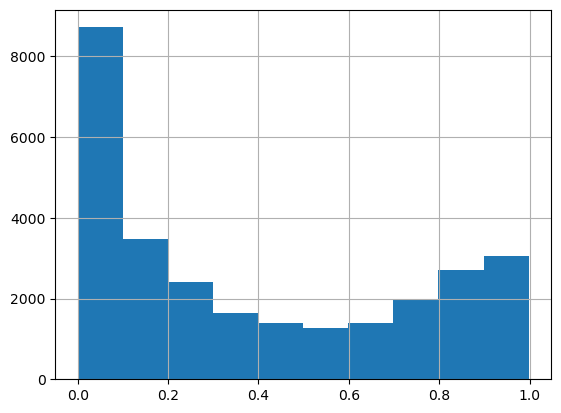

In [38]:
submission.booking_status.hist()

In [39]:
train = pd.read_csv('/kaggle/input/playground-series-s3e7/train.csv')
# train = pd.concat([train, addition_data],axis=0)
test = pd.read_csv('/kaggle/input/playground-series-s3e7/test.csv')

y = 'booking_status'
dup_features = test.drop(columns='id').columns.tolist()
values_to_assign = test.merge(train.drop(columns='id'), on=dup_features, how='inner')[['id', y]]
map_di = {0: submission[y].max(), 1: submission[y].min()}
submission.loc[submission.id.isin(values_to_assign.id), y] = values_to_assign[y].map(map_di).values
submission.loc[submission.id.isin(values_to_assign.id), y]

submission.to_csv('submission.csv', index=False)
submission.loc[submission.id.isin(values_to_assign.id)].head(10)

,id,booking_status
48,42148,0.000021
92,42192,0.000021
159,42259,0.000021
300,42400,0.000021
319,42419,0.000021
346,42446,0.000021
374,42474,0.998137
429,42529,0.000021
472,42572,0.998137
537,42637,0.998137


<AxesSubplot:>

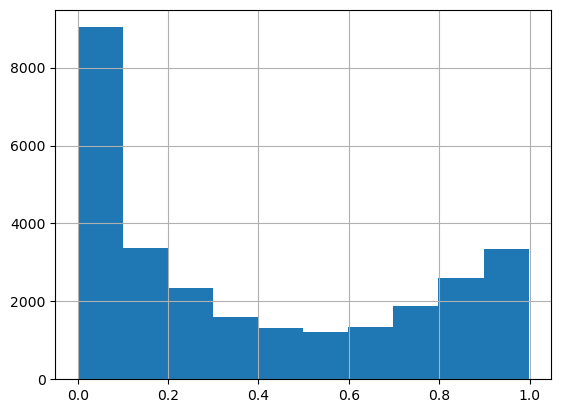

In [40]:
submission.booking_status.hist()